In [1]:
import torch 
import torchvision
from typing import List, Tuple
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, SequentialSampler

import clip

import numpy as np 
import cv2 
from PIL import Image, ImageDraw 

import json 
from tqdm import tqdm 

In [2]:
class paths:
    panorama = '/data1/saaket/jpegs_manhattan_touchdown_2021/'
    pano_slice = '/data1/saaket/lsd_data/data/processed/pano_slices/'
    touchdown= '/data1/saaket/touchdown/data/'
    train = touchdown + 'train.json'
    dev = touchdown + 'dev.json'
    test = touchdown + 'test.json'
    device = 'cuda:5' if torch.cuda.is_available() else 'cpu'

In [3]:
class ImageList:
    """
    Structure that holds a list of images (of possibly
    varying sizes) as a single tensor.
    This works by padding the images to the same size,
    and storing in a field the original sizes of each image
    Args:
        tensors (tensor): Tensor containing images.
        image_sizes (list[tuple[int, int]]): List of Tuples each containing size of images.
    """

    def __init__(self, tensors: Tensor, image_sizes: List[Tuple[int, int]]) -> None:
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device: torch.device) -> "ImageList":
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

# If computing bounding boxes on the entire panorama, uncomments this code block 
#####
class RPNDataset(Dataset):
    def __init__(self, panorama_list, transforms):
        self.panorama_list = panorama_list 
        self.transforms = transforms 
    
    def __len__(self):
        return len(self.panorama_list)

    
    def __getitem__(self, idx):
        pano = Image.open(paths.panorama + self.panorama_list[idx] + '.jpg')

        return self.transforms(pano)
#####

# If computing bounding boxes on all perspective images separately uncomment the below code 
####
# class RPNDataset(Dataset):
#     def __init__(self, image_list, transforms):
#         self.image_list = image_list 
#         self.pano_slice_path = '/data1/saaket/lsd_data/data/processed/pano_slices' 
#         self.arranged_image_list = self.arrange_images()
#         self.transforms = transforms
    
#     def __len__(self):
#         return len(self.arranged_image_list)

#     def arrange_images(self):
#         arranged_image_list = []
#         for parent_image in self.image_list:
#             child_images = [f'{self.pano_slice_path}/{parent_image}/{parent_image}_{i}.jpg' for i in range(8)]
#             arranged_image_list.extend(child_images)
#         return arranged_image_list

#     def __getitem__(self, idx):
#         img = Image.open(self.arranged_image_list[idx])
#         try:
#             img_tfms = self.transforms(img)
#         except:
#             print(self.arranged_image_list[idx] + ' has failed')
#         return img_tfms 
####

class AnchorImageDataset(Dataset):
    def __init__(self, image, coords, transforms):
        self.image = image.copy()
        self.coords = coords
        self.transforms = transforms

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        coord = self.coords[idx]
        return self.transforms(self.image.crop(coord))

In [4]:
def generate_bounding_boxes(unique_panos, device):
    fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
    fasterRCNN.eval() 
    fasterRCNN.to(device)


    tfms = torchvision.transforms.Compose([
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float)
    ])
    
    # model, transform = clip.load('RN50', device=device)
    
    rpn_dataset = RPNDataset(unique_panos, tfms)
    
    rpn_loader = DataLoader(rpn_dataset, batch_size=8, num_workers=8)
    bboxes = []
    for enum, imgData in enumerate(tqdm(rpn_loader)):
        imlist = ImageList(imgData, [tuple(i.size()[1:]) for i in imgData])
        imlist = imlist.to(device)
        features = fasterRCNN.backbone(imlist.tensors)
        with torch.no_grad():
            proposals, proposal_losses = fasterRCNN.rpn(imlist, features, )
        # props = proposals.detach().to('cpu').int()#.numpy().tolist()
        props = [p.detach().to('cpu').int().numpy().tolist() for p in proposals]
        del imlist 
        bboxes.extend(props)
    return bboxes 

In [4]:
def get_unique_panos(data_path):
    '''Compute unique panoramasa from data file. These panos are unique to a particular train/dev/test file'''
    panoids = []
    with open(data_path) as f:
        for idx, line in enumerate(f):
            obj = json.loads(line)
            panoids.append(obj['main_pano'])
    return np.unique(panoids)

def get_pano2id(unique_panos):
    pano2id = {}
    id2pano = {}
    for i, pano in enumerate(unique_panos):
        pano2id[pano] = i 
        id2pano[i] = pano
    return pano2id, id2pano 

def touchdown_loader(data_path):
    texts, panoids = [], []
    with open(data_path) as f:
        for idx, line in enumerate(f):
            obj = json.loads(line)
            panoids.append(obj['main_pano'])
            texts.append(obj['td_location_text'])
    return texts, panoids 


unique_panos = get_unique_panos(paths.train)
text, panoids = touchdown_loader(paths.train)
pano2id, id2pano = get_pano2id(unique_panos)
device = paths.device 


In [5]:
# bounding_boxes = generate_bounding_boxes(unique_panos[:5], device)
# bounding_boxes = np.load(f'/data2/saaket/best_dev_boxes_pano.npy')
bounding_boxes = np.load('../src/data/sdr_bboxes_train.npy')

In [9]:
def compute_area(box):
    x1, y1, x2, y2 = box 

    return (y2-y1)*(x2-x1)

In [35]:
test_set = bounding_boxes[6*8:7*8]

for i in range(8):
    for j, box in enumerate(test_set[i]):
        area = compute_area(box)
        if area <= 1:
            print(box, area, i, j)



[  0 791   0 800] 0 6 223
[  0 480   0 491] 0 7 745
[  0 791   0 800] 0 7 835


In [12]:
test_set.shape

(8, 1000, 4)

In [30]:
len(bounding_boxes)

44456

In [32]:
counter = 0
for i in range(len(bounding_boxes)):
    for j in range(8):
        degen_boxes = bounding_boxes[i, :, 2:] <= bounding_boxes[i, :, :2]
        if degen_boxes.any():
            counter += 1 
print(counter)


11496


In [19]:
def visualize_bounding_boxes(panoid, sliceid, bboxes, n_boxes):
    image = Image.open(paths.pano_slice + panoid + f'/{panoid}_{sliceid}.jpg')
    for box in bboxes[:n_boxes]:
        x1, y1, x2, y2 = box 
        draw = ImageDraw.Draw(image)
        draw.rectangle((x1, y1, x2, y2), outline=(255, 0, 0), width=1)
    return image 

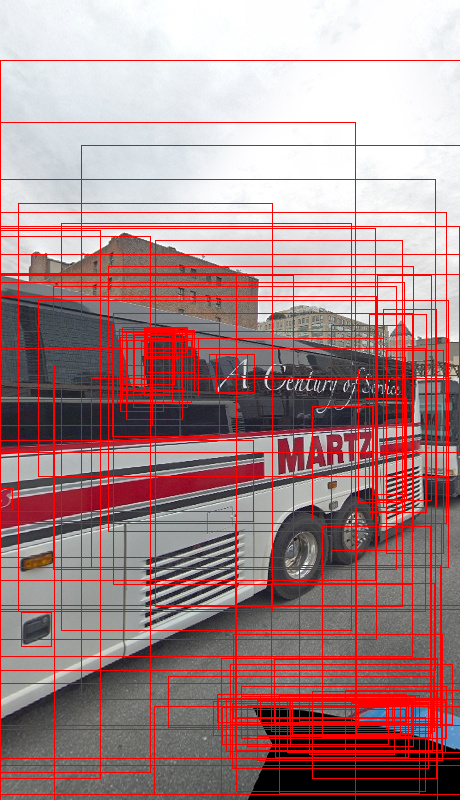

In [24]:
visualize_bounding_boxes(unique_panos[6], 7, bounding_boxes[8*6 + 7], 100)

In [9]:
import os
prefixed = [filename for filename in os.listdir('/data2/saaket/') if filename.startswith("image_features_sdr_pano")]
image_features = [] 
for file in prefixed:
    image_features.extend(torch.load(f'/data2/saaket/{file}', map_location='cpu'))

In [19]:
image_features = [feat.cpu() for feat in image_features]

In [10]:
image_features = torch.stack(image_features) 

In [11]:
image_features.size()

torch.Size([6899, 1000, 512])

In [20]:
def compute_image_features_and_detect_region(panoid, bboxes, td_text, transform, detector):
    
    def compute_anchor_features(model, device, anchor_loader):
        anchor_features = []
        for anchor_batch in anchor_loader:
            with torch.no_grad():
                anchor_features_ = model.encode_image(anchor_batch.to(device))
            anchor_features.append(anchor_features_)
        
        anchor_features = torch.vstack(anchor_features)
        anchor_features /= anchor_features.norm(p=2, dim=-1, keepdim=True)
        return anchor_features

    panorama = Image.open(paths.panorama + panoid + '.jpg')
    
    anchor_dataset = AnchorImageDataset(panorama, bboxes, transform)
    anchor_loader = DataLoader(anchor_dataset, 
                batch_size=1000, 
                sampler=SequentialSampler(anchor_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=8,)
    image_features = compute_anchor_features(detector, 'cuda:4', anchor_loader)
    
    text_arr = td_text.split('.')
    text_arr.remove('')

    tokens = clip.tokenize(text_arr).to('cuda:4')
    with torch.no_grad():
        text_features = detector.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    print(image_features.size(), text_features.size()) 
    similarity_scores = image_features @ text_features.T 
    
    return similarity_scores

In [13]:
def detect_regions(image_features, td_text, text_encoder):

    text_arr = td_text.split('.')
    text_arr.remove('')

    tokens = clip.tokenize(text_arr).to(device)
    with torch.no_grad():
        text_features = text_encoder.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity_scores = image_features @ text_features.T 

    return similarity_scores 
    

In [15]:
for i, pid in enumerate(panoids):
    if pid == unique_panos[1]:
        print(i)
        break 

786


In [16]:
model, transform = clip.load('ViT-B/32', device='cuda:4')

In [21]:
scores = compute_image_features_and_detect_region(panoids[786], bounding_boxes[pano2id[panoids[786]]], text[786], transform, model)

torch.Size([1000, 512]) torch.Size([2, 512])


In [13]:
scores.size()

torch.Size([1000, 2])

In [22]:
def visualize_regions(idx):
    bbox = [bounding_boxes[pano2id[panoids[idx]]][i] for i in scores.argmax(dim=0).cpu().tolist()]; bbox
    image = Image.open(paths.panorama + panoids[idx] + '.jpg')
    colors = ['red', 'blue', 'green']
    for cid, box in enumerate(bbox):
        x1, y1, x2, y2 = box 
        draw = ImageDraw.Draw(image)
        draw.rectangle((x1, y1, x2, y2), outline=colors[cid])
    return image 


In [23]:
print(text[786])

see the construction lights on the left with a generator beside it. Touchdown is sitting on top of the orange cone beside the generator.


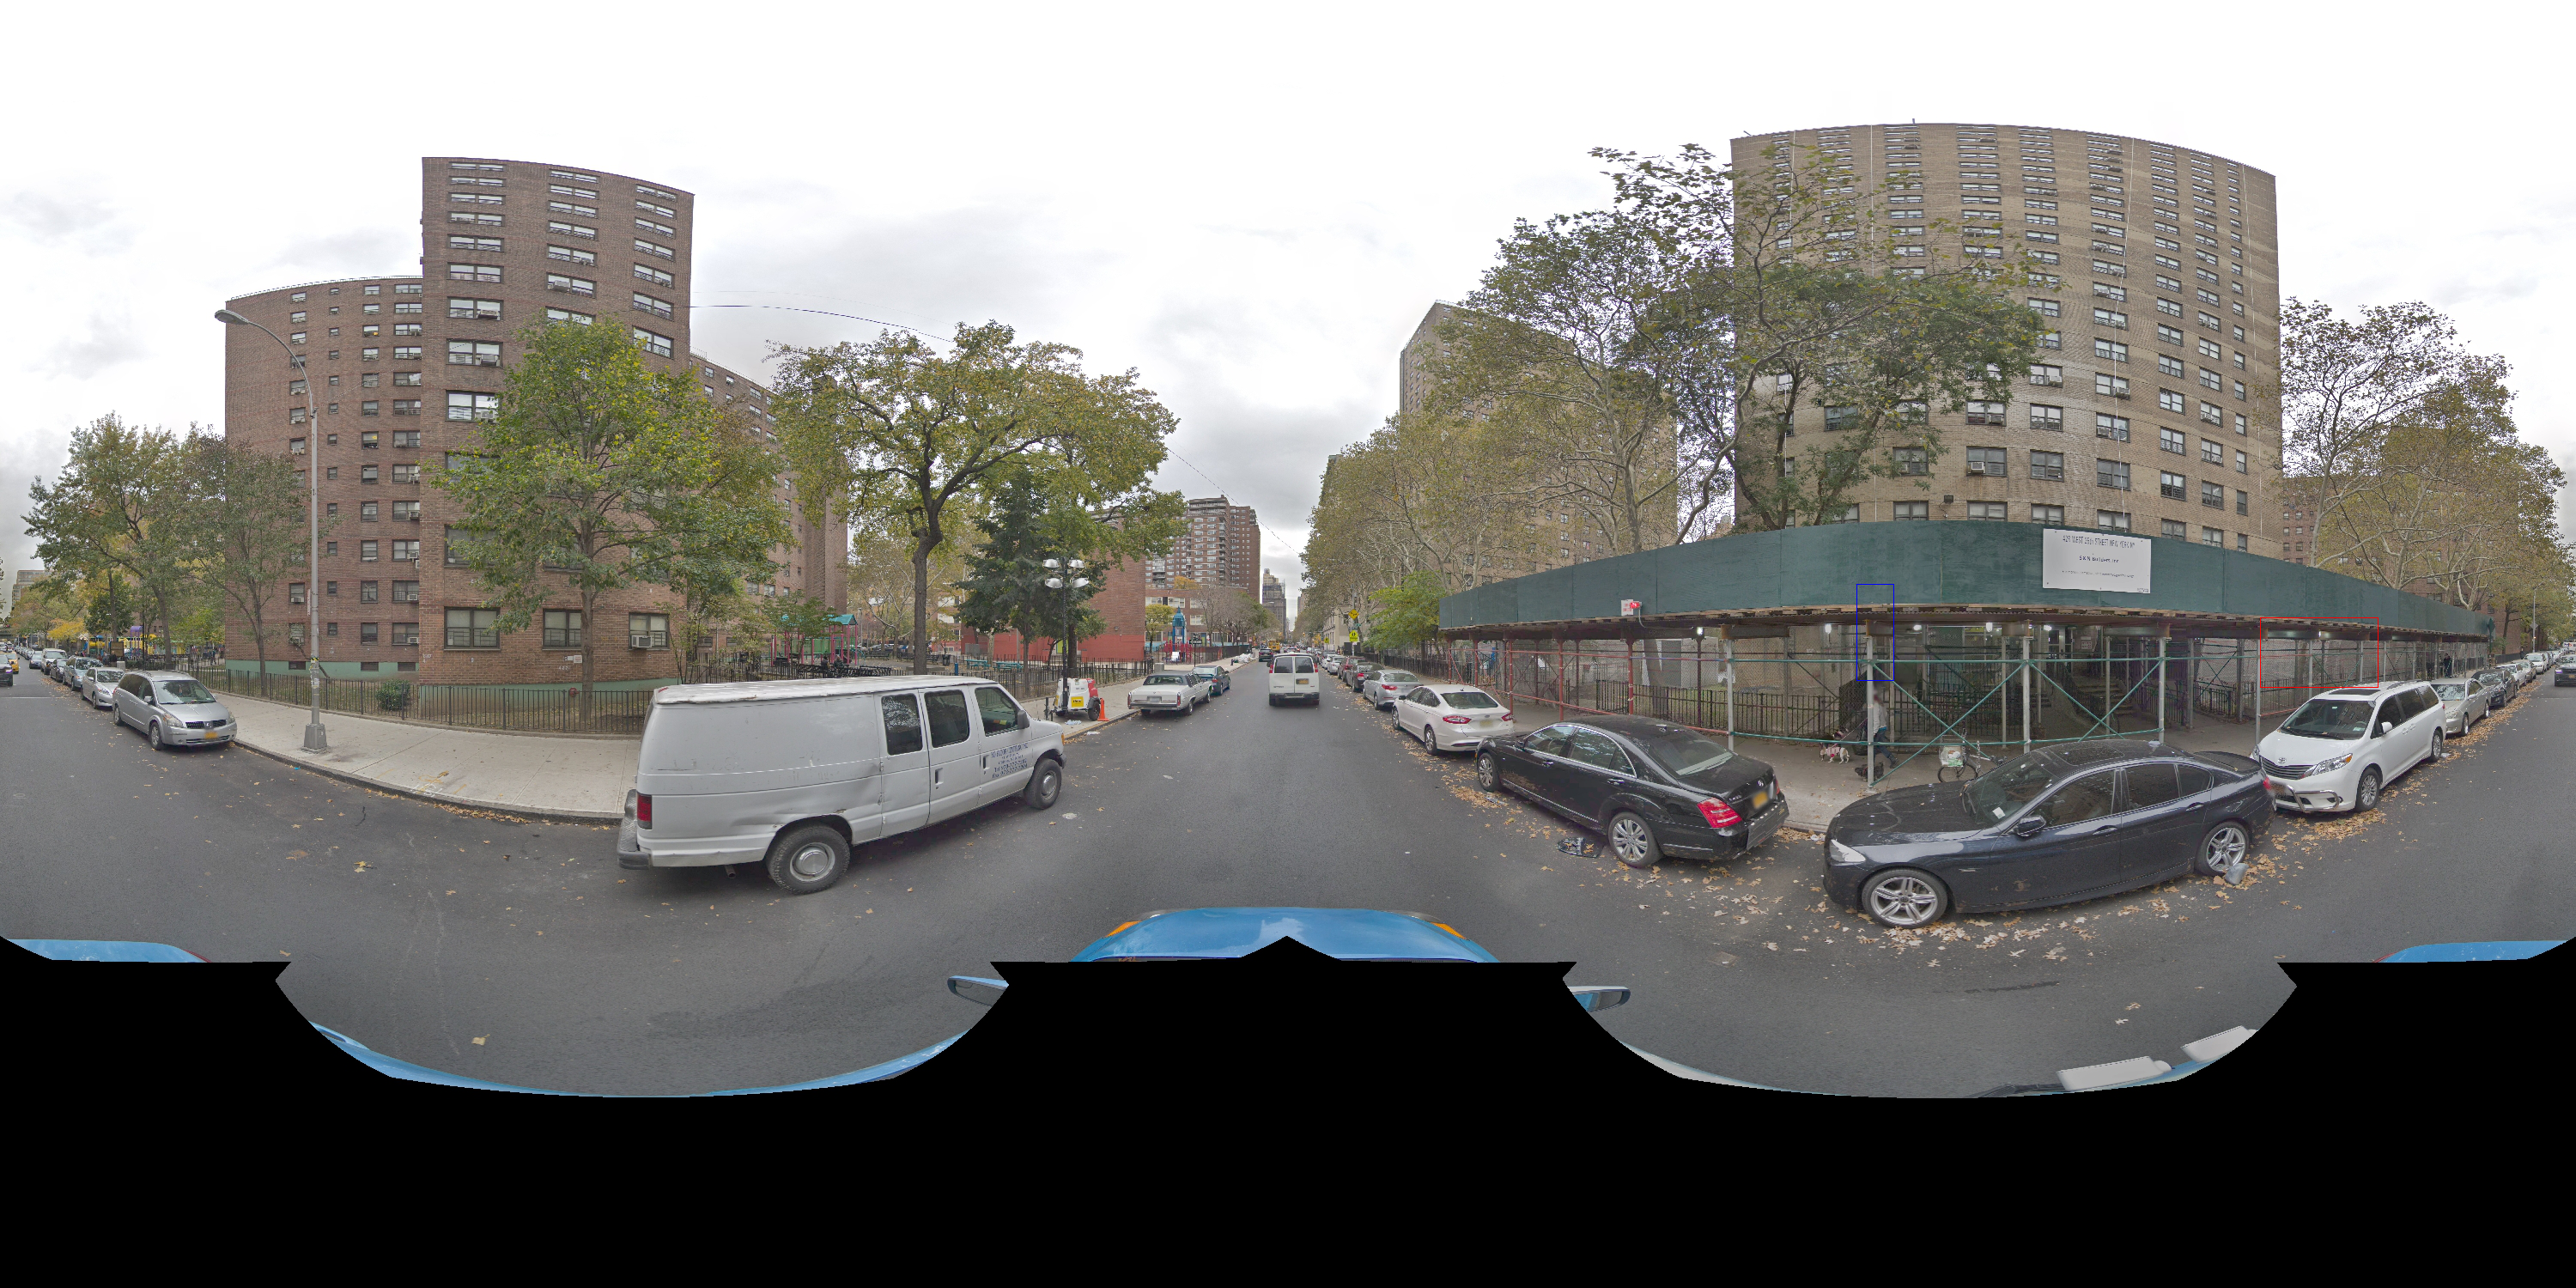

In [24]:
visualize_regions(786)

In [27]:
def annotate_images(scores, ):
    images = []
    bbox_id = int(np.where(unique_panos == panoid)[0])
    print(bbox_id)
    for raw_box_id in scores.argmax(dim=0):
        slice_offset = int(raw_box_id) // 1000
        box_num = int(raw_box_id) % 1000
        bbox = bboxes[bbox_id + slice_offset][box_num]
        x1, y1, x2, y2 = bbox 
        img = Image.open(f'{PANO_SLICE_DIRECTORY}/{panoid}/{panoid}_{slice_offset}.jpg' )
        draw = ImageDraw.Draw(img)
        draw.rectangle((x1, y1, x2, y2), outline=(255, 255, 255))
        images.append(img)

    return images 

tensor(614, device='cuda:0')

In [46]:
detect_region()

178